In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
import keras
from keras.applications.mobilenet import MobileNet

from sklearn.metrics import confusion_matrix
from keras.metrics import categorical_crossentropy
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.preprocessing import image

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/val',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

test = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/test',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

Found 5633 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 1597 images belonging to 2 classes.


In [ ]:
MobileNetv2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
MobileNetv2.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
  MobileNetv2,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=2, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1024)              64226304  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                        

In [ ]:
history = model.fit(
    x = train,
    validation_data = validation,
    epochs = 5
)

Epoch 1/5
177/177 [==============================] - 1753s 10s/step - loss: 0.6922 - accuracy: 0.9027 - val_loss: 0.1485 - val_accuracy: 0.9512
Epoch 2/5
177/177 [==============================] - 322s 2s/step - loss: 0.1781 - accuracy: 0.9432 - val_loss: 0.2372 - val_accuracy: 0.9262
Epoch 3/5
177/177 [==============================] - 343s 2s/step - loss: 0.1638 - accuracy: 0.9464 - val_loss: 0.1502 - val_accuracy: 0.9437
Epoch 4/5
177/177 [==============================] - 331s 2s/step - loss: 0.1184 - accuracy: 0.9560 - val_loss: 0.2192 - val_accuracy: 0.9312
Epoch 5/5
177/177 [==============================] - 332s 2s/step - loss: 0.1096 - accuracy: 0.9601 - val_loss: 0.1504 - val_accuracy: 0.9437


In [ ]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

50/50 [==============================] - 560s 11s/step - loss: 0.1166 - accuracy: 0.9574
Accuracy: 0.9574201703071594
Loss: 0.11664467304944992


In [ ]:
test.class_indices

{'Defect': 0, 'Fresh': 1}

In [ ]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['Defect', 'Fresh']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

50/50 [==============================] - 12s 226ms/step
              precision    recall  f1-score   support

      Defect       1.00      0.91      0.95       727
       Fresh       0.93      1.00      0.96       870

    accuracy                           0.96      1597
   macro avg       0.96      0.95      0.96      1597
weighted avg       0.96      0.96      0.96      1597



<Axes: >

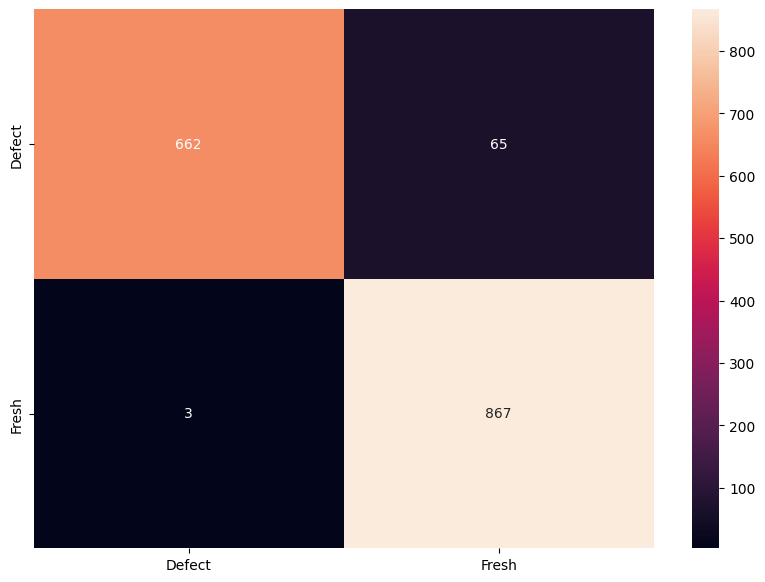

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Defect', 'Fresh']],
                  columns = [i for i in ['Defect', 'Fresh']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

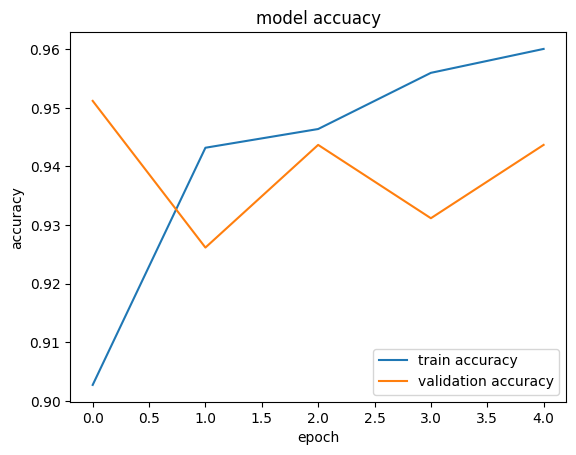

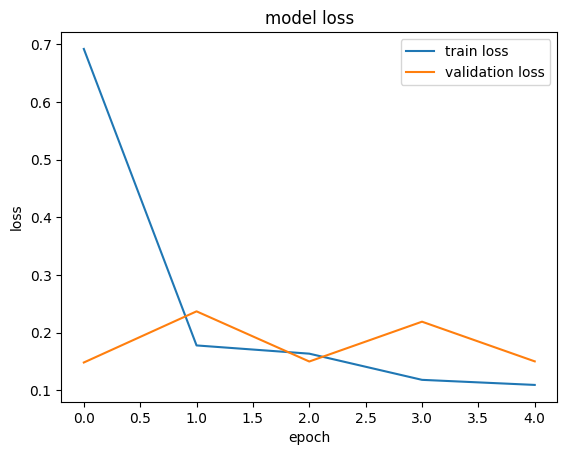

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()